In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

In [2]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [3]:
# max_component_num = 100
# max_bezier_curve_num = 1000

# image_floder = 'CS 3570 Final Project Topic5'
max_component_num = 20
max_bezier_curve_num = 200

image_floder = '128'

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100)

In [4]:
import numpy as np
from scipy.linalg import lstsq
from scipy.spatial import distance

def compute_arc_length_params(points):
    """
    計算弧長參數化的參數 t_i
    :param points: 样本点列表 [(x0, y0), (x1, y1), ..., (xn, yn)]
    :return: 弧长参数化后的参数列表 [t0, t1, ..., tn]
    """
    n = len(points)
    dists = [np.linalg.norm(np.array(points[i]) - np.array(points[i-1])) for i in range(1, n)]
    s = [0] + np.cumsum(dists).tolist()
    total_length = s[-1]
    t = [si / total_length for si in s]
    return t

def fit_bezier_curve(points):
    """
    拟合三次贝塞尔曲线
    :param points: 样本点列表 [(x0, y0), (x1, y1), ..., (xn, yn)]
    :return: 控制点 [(P0x, P0y), (P1x, P1y), (P2x, P2y), (P3x, P3y)]
    """
    points = np.array(points)
    t = compute_arc_length_params(points)
    
    # 设定 P0 和 P3
    P0 = points[0]
    P3 = points[-1]
    
    # 构建矩阵 A 和向量 B
    A = []
    Bx = []
    By = []
    
    for i in range(1, len(points) - 1):
        ti = t[i]
        A.append([3 * (1 - ti)**2 * ti, 3 * (1 - ti) * ti**2])
        Bx.append(points[i, 0] - ((1 - ti)**3 * P0[0] + ti**3 * P3[0]))
        By.append(points[i, 1] - ((1 - ti)**3 * P0[1] + ti**3 * P3[1]))
    
    A = np.array(A)
    Bx = np.array(Bx)
    By = np.array(By)
    
    # 解最小二乘问题
    Px, _, _, _ = lstsq(A, Bx)
    Py, _, _, _ = lstsq(A, By)
    
    P1 = (Px[0], Py[0])
    P2 = (Px[1], Py[1])
    
    return [tuple(P0), P1, P2, tuple(P3)],t

def bezier_curve(t, p0, p1, p2, p3):
    """
    计算贝塞尔曲线上的点
    :param t: 参数t（0到1之间）
    :param p0: 控制点P0
    :param p1: 控制点P1
    :param p2: 控制点P2
    :param p3: 控制点P3
    :return: 贝塞尔曲线上的点
    """
    return (1-t)**3 * p0 + 3*(1-t)**2 * t * p1 + 3*(1-t) * t**2 * p2 + t**3 * p3

def compute_approximation_error(points, control_points, points_t):
    """
    计算逼近误差
    :param points: 样本点列表 [(x0, y0), (x1, y1), ..., (xn, yn)]
    :param control_points: 控制点列表 [(P0x, P0y), (P1x, P1y), (P2x, P2y), (P3x, P3y)]
    :return: 逼近误差
    """
    total_error = 0
    n = len(points)
    
    # 遍历样本点
    for point, t in zip(points,points_t):
        curve_point = bezier_curve(t, *control_points)
        dist = distance.euclidean(point, curve_point)
        total_error +=dist
    
    return total_error

def fit_bezier_curve_and_error(points):
    control_points,points_t = fit_bezier_curve(points)
    loss=compute_approximation_error(points,np.array(control_points),points_t)
    return control_points,loss

def mask_to_contours(mask):
    mask = mask.astype(np.uint8)*255
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours_points = []
    filled_masks_area = []
    filled_masks = []
    for contour in contours:
        filled_mask = np.zeros(mask.shape, dtype=np.uint8)
        cv2.drawContours(filled_mask, [contour], -1, (1), thickness=cv2.FILLED)
        filled_masks.append(filled_mask)
        filled_masks_area.append(np.sum(filled_mask))
        contours_points.append(np.concatenate([contour[:, 0, :],contour[:1, 0, :]],0)+0.5)
    return contours_points,filled_masks,filled_masks_area

In [5]:
def write_svg(filename,sorted_masks,scale):
    with open(filename, 'w') as f:
        f.write('<svg xmlns="http://www.w3.org/2000/svg" width="'+str(scale[3])+'" height="'+str(scale[2])+'" viewbox="0 0 '+str(scale[3])+' '+str(scale[2])+'">\n')
        for ma in sorted_masks:
            control_points_sets = ma["control_points_sets"]
            rgb = ma["color"]
            control_points = control_points_sets[0]["control_points"]
            f.write('<path d="M {:.2f} {:.2f} '.format(control_points[0][0]*scale[1], control_points[0][1]*scale[0]))
            for control_points_set in control_points_sets:
                control_points = control_points_set["control_points"]
                f.write('C {:.2f} {:.2f}, {:.2f} {:.2f}, {:.2f} {:.2f} '.format(control_points[1][0]*scale[1], control_points[1][1]*scale[0],control_points[2][0]*scale[1], control_points[2][1]*scale[0], control_points[3][0]*scale[1],control_points[3][1]*scale[0]))
            f.write('Z" fill="rgb('+str(rgb[0])+','+str(rgb[1])+','+str(rgb[2])+')" stroke="rgb('+str(rgb[0])+','+str(rgb[1])+','+str(rgb[2])+')" stroke-width="1" />\n')
        f.write('</svg>')

In [6]:
def SAMVGV1(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    scale = [1,1,image.shape[0],image.shape[1]]
    if image.shape[0]*image.shape[1]>1024*1024:
        scale = [image.shape[0]/1024,image.shape[1]/1024,image.shape[0],image.shape[1]]
        image = cv2.resize(image, (1024, 1024))
    masks = mask_generator.generate(image)
    m=np.ones(image.shape[0:2])
    # 找輪廓
    contours_points,filled_masks,filled_masks_area=mask_to_contours(m)
    ma = dict()
    ma["contours_points"] = contours_points[0]
    ma["filled_mask"] = filled_masks[0]
    ma["filled_mask_area"] = filled_masks_area[0]
    new_masks=[ma]
    for i in range(len(masks)):
        m = masks[i]['segmentation']
        contours_points,filled_masks,filled_masks_area=mask_to_contours(m)
        for i in range(len(contours_points)):
            ma = dict()
            ma["contours_points"] = contours_points[i]
            ma["filled_mask"] = filled_masks[i]
            ma["filled_mask_area"] = filled_masks_area[i]
            if len(ma["contours_points"])>=4:
                new_masks.append(ma)
    sorted_masks = sorted(new_masks, key=(lambda x: x['filled_mask_area']), reverse=True)[:max_component_num]
    # 優化bezier_curve
    use_bezier_curve_num = 0
    for ma in sorted_masks:
        control_points,loss=fit_bezier_curve_and_error(ma["contours_points"])
        control_points_set = dict()
        control_points_set["control_points"]=control_points
        control_points_set["loss"]=loss
        control_points_set["range"]=[0,len(ma["contours_points"])-1]
        ma["control_points_sets"]=[control_points_set]
        use_bezier_curve_num+=1
        if use_bezier_curve_num>=max_bezier_curve_num:
            break
        
    while use_bezier_curve_num<max_bezier_curve_num:
        use_bezier_curve_num+=1
        max_loss_control_points_set = sorted_masks[0]["control_points_sets"][0]
        max_loss_ma_index = 0
        max_loss_ma_control_points_sets_index = 0
        for i1,ma in enumerate(sorted_masks):
            for i2,control_points_set in enumerate(ma["control_points_sets"]):
                if control_points_set["loss"]>max_loss_control_points_set["loss"]:
                    max_loss_control_points_set = control_points_set
                    max_loss_ma_index = i1
                    max_loss_ma_control_points_sets_index = i2
        if max_loss_control_points_set["range"][1]-max_loss_control_points_set["range"][0]<8:
            break
        ma = sorted_masks[max_loss_ma_index]
        sorted_masks[max_loss_ma_index]["control_points_sets"].pop(max_loss_ma_control_points_sets_index)
        control_points_set = dict()
        mt=int((max_loss_control_points_set["range"][0]+max_loss_control_points_set["range"][1])//2)
        t1=max_loss_control_points_set["range"][0]
        t2=mt
        control_points,loss=fit_bezier_curve_and_error(ma["contours_points"][t1:t2])
        control_points_set["control_points"]=control_points
        control_points_set["loss"]=loss
        control_points_set["range"]=[t1,t2]
        ma["control_points_sets"].insert(max_loss_ma_control_points_sets_index,control_points_set)
        control_points_set = dict()
        t1=mt
        t2=max_loss_control_points_set["range"][1]
        control_points,loss=fit_bezier_curve_and_error(ma["contours_points"][t1:t2])
        control_points_set["control_points"]=control_points
        control_points_set["loss"]=loss
        control_points_set["range"]=[t1,t2]
        ma["control_points_sets"].insert(max_loss_ma_control_points_sets_index+1,control_points_set)
    print(image_path+":out ",use_bezier_curve_num)
    # 決定顏色
    sorted_masks.reverse()
    image_color_mask = np.ones(sorted_masks[0]["filled_mask"].shape)
    for i,ma in enumerate(sorted_masks):
        tm = image_color_mask*ma["filled_mask"]
        sorted_masks[i]["color"] = np.sum(image * np.expand_dims(tm,2),(0,1))/np.sum(tm)
        image_color_mask = image_color_mask * (1-ma["filled_mask"])
    sorted_masks.reverse()
    write_svg('SVG_'+image_path.split('.')[0]+'.svg', sorted_masks,scale)

In [7]:
#evaluation
def calculate_mse(image1, image2):
    image1 = cv2.imread(image1)
    image2 = cv2.imread(image2)
    # Ensure images are the same shape
    if image1.size != image2.size:
        raise ValueError("Images must have the same dimensions for MSE calculation")
    


    
    # Compute MSE
    mse = np.mean((image1 - image2) ** 2)
    return mse


128\fallingwater.jpg:out  200


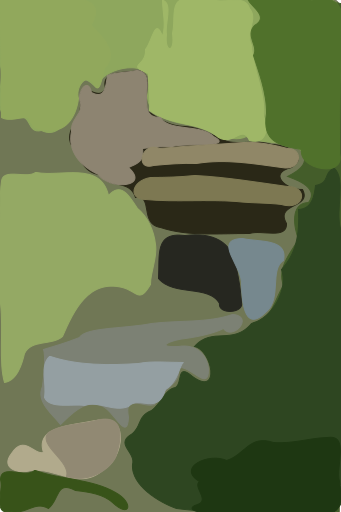

128\fallingwater.jpg vs SVG2PNG_128\fallingwater.png: 100.74397261424731
128\tree.png:out  200


C:\Users\a5658\AppData\Local\Temp\ipykernel_6512\2369992475.py:79: RuntimeWarning: invalid value encountered in divide
  sorted_masks[i]["color"] = np.sum(image * np.expand_dims(tm,2),(0,1))/np.sum(tm)


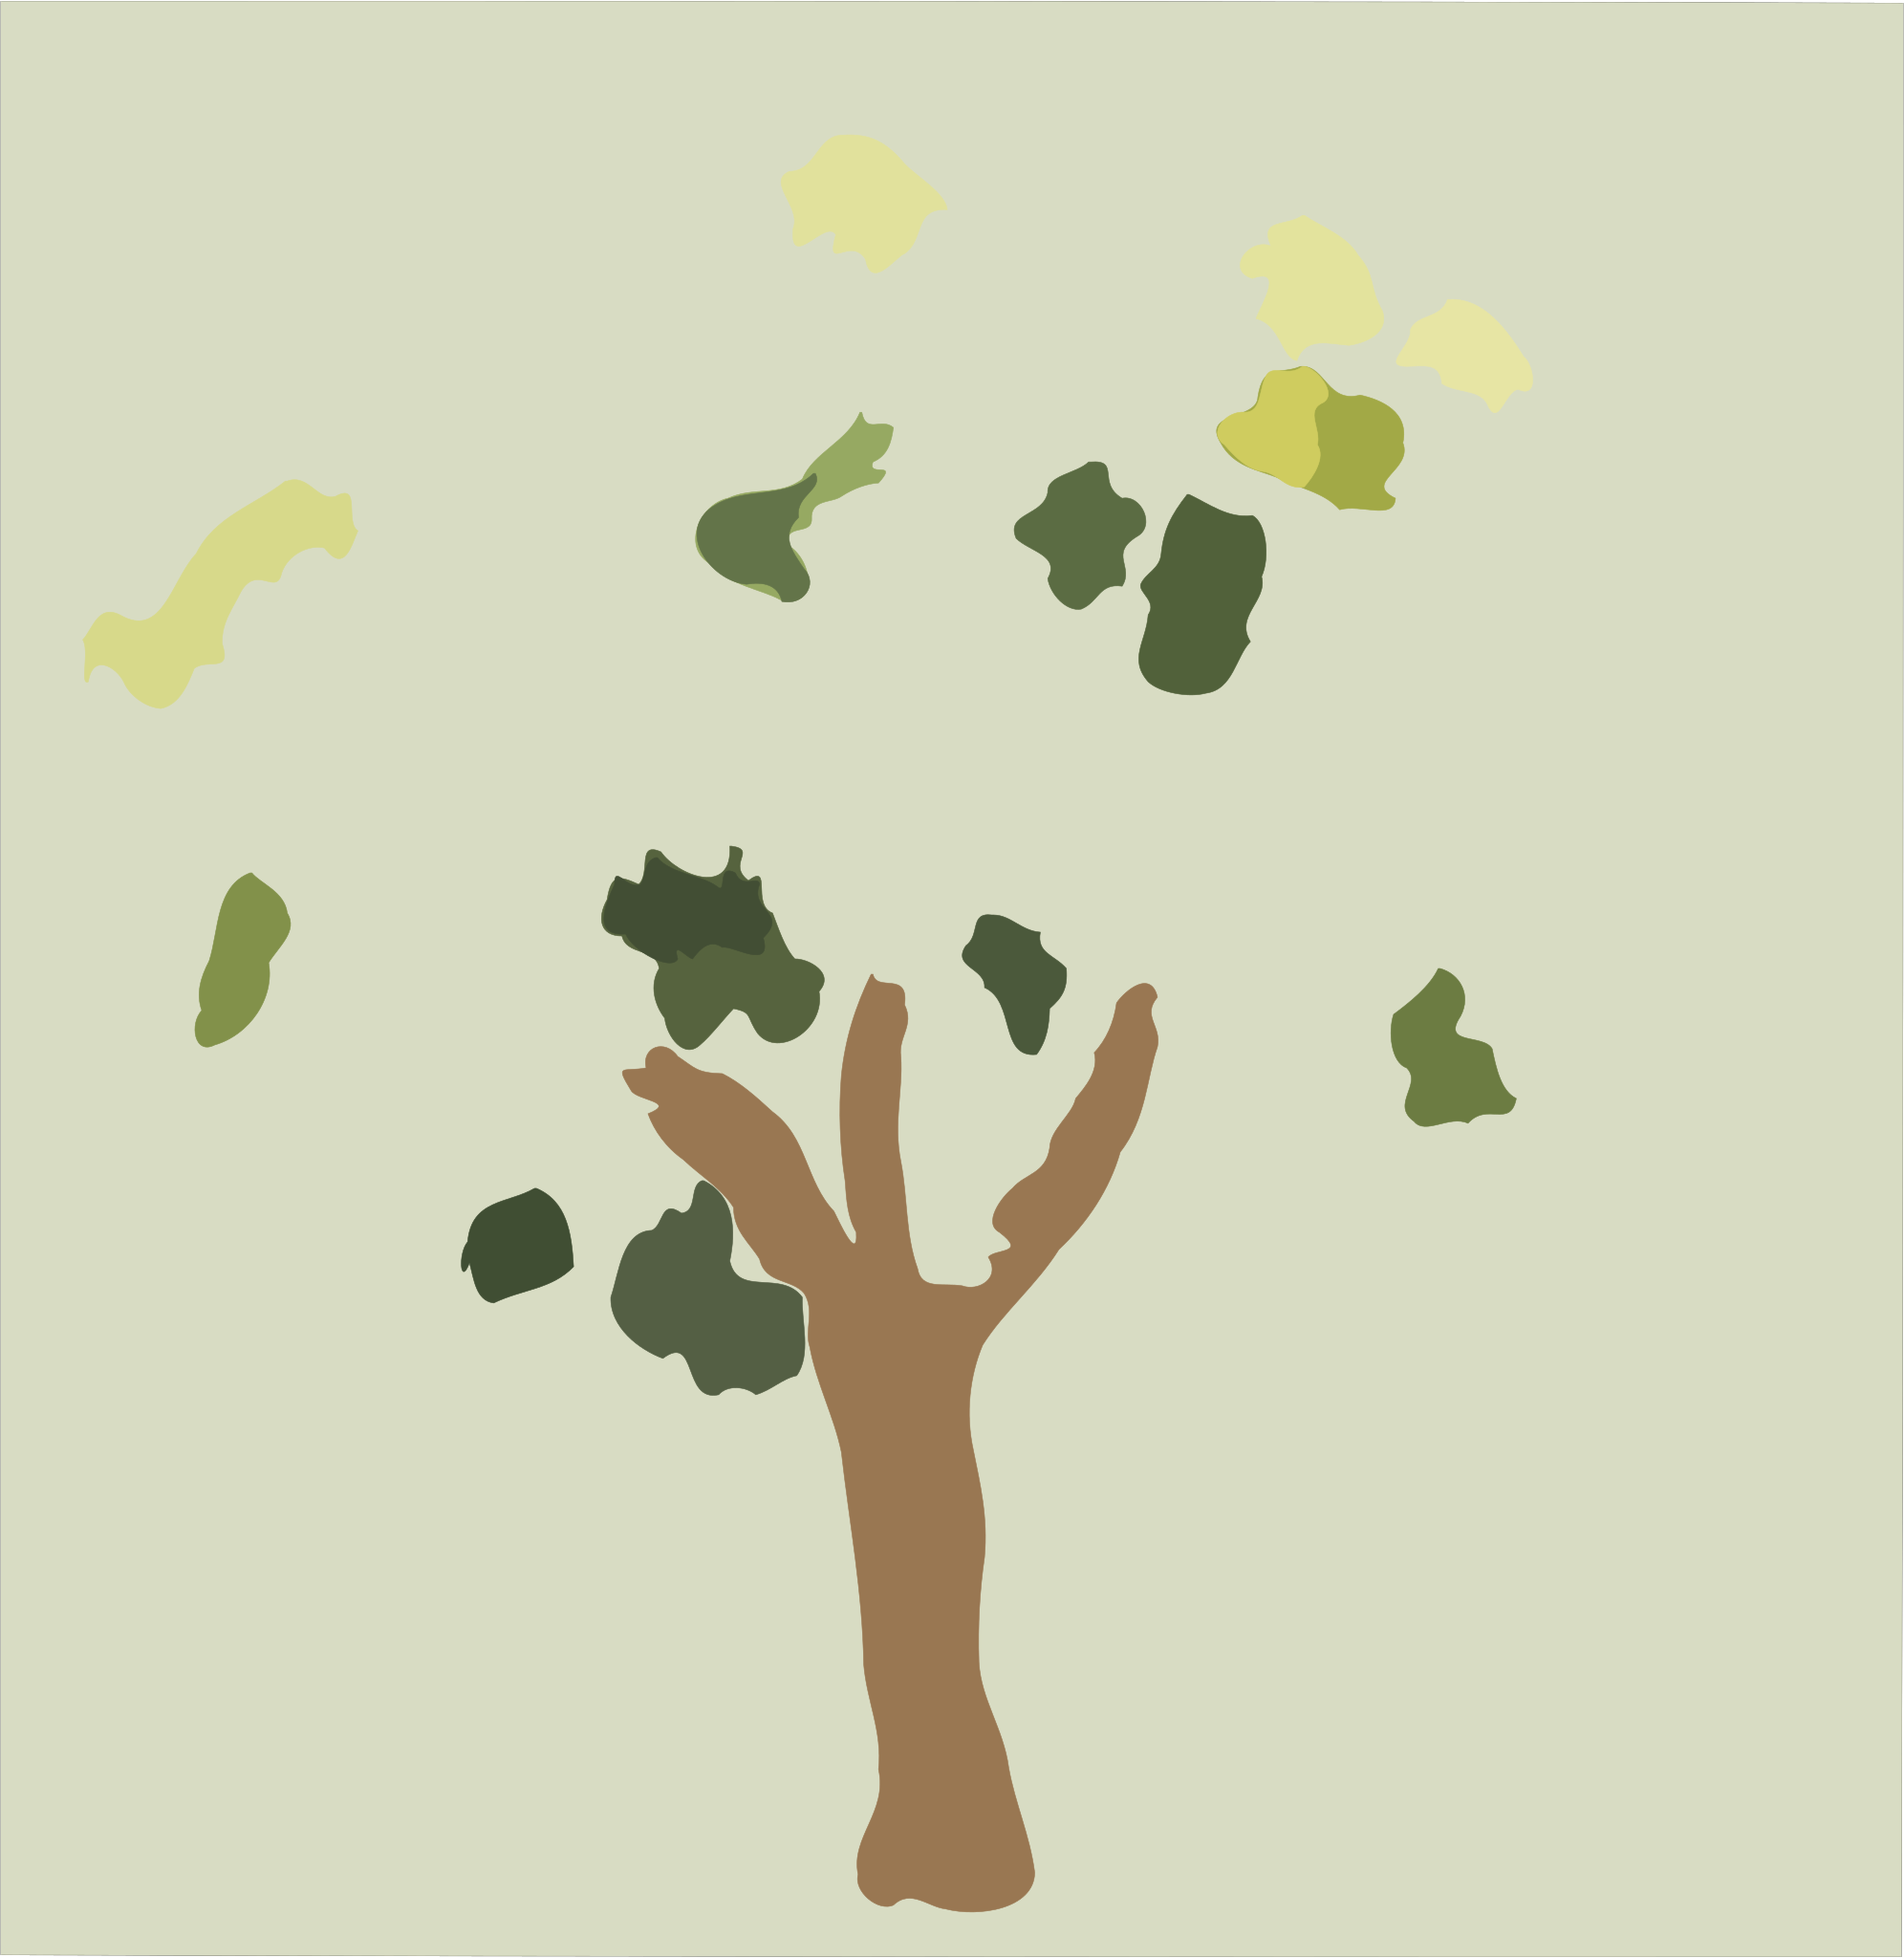

128\tree.png vs SVG2PNG_128\tree.png: 124.4193101859432
128\hot-air-balloon.jpg:out  200


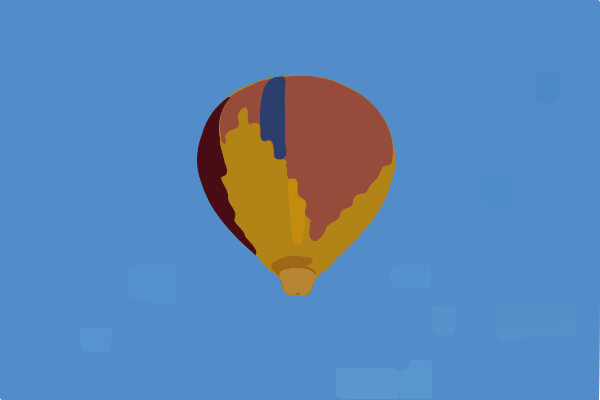

128\hot-air-balloon.jpg vs SVG2PNG_128\hot-air-balloon.png: 28.507683333333333
128\emoji_u1faf2_1f3fe.png:out  179


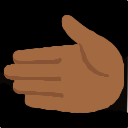

128\emoji_u1faf2_1f3fe.png vs SVG2PNG_128\emoji_u1faf2_1f3fe.png: 8.711140950520834
128\emoji_u1faf3_1f3fc.png:out  187


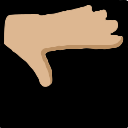

128\emoji_u1faf3_1f3fc.png vs SVG2PNG_128\emoji_u1faf3_1f3fc.png: 8.86895751953125
128\emoji_u1faf2_1f3ff.png:out  154


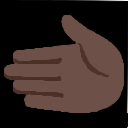

128\emoji_u1faf2_1f3ff.png vs SVG2PNG_128\emoji_u1faf2_1f3ff.png: 9.202412923177084
128\flower.jpg:out  200


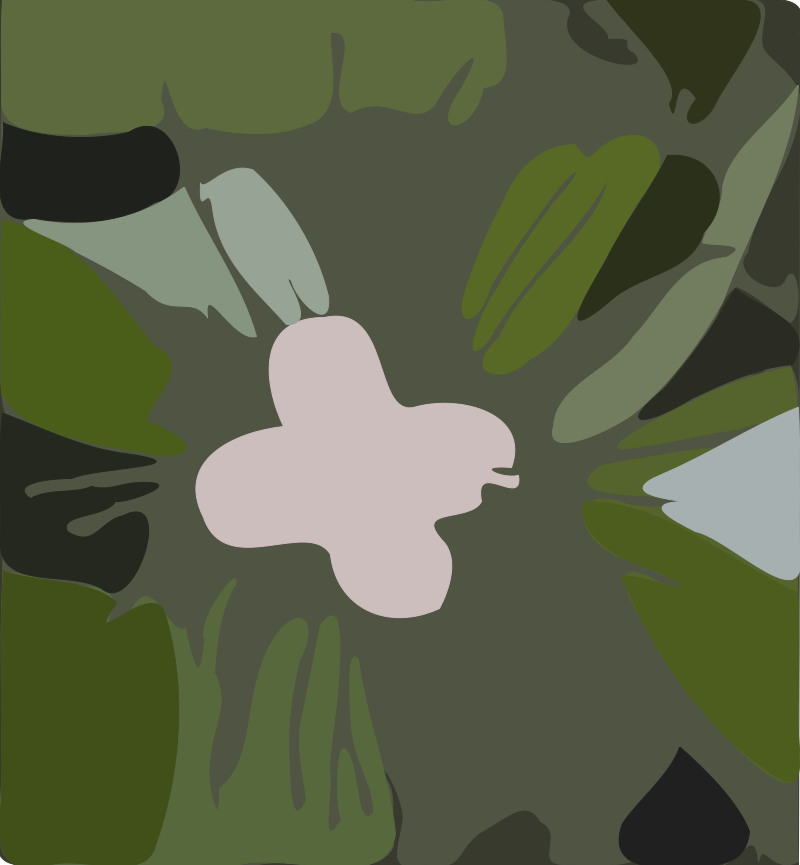

128\flower.jpg vs SVG2PNG_128\flower.png: 92.05764499036609
128\house.png:out  200


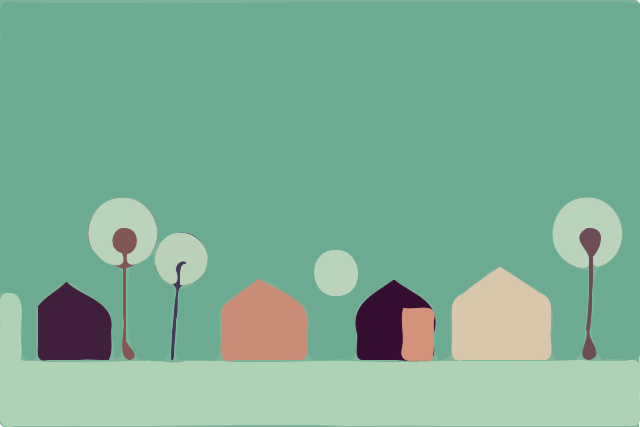

128\house.png vs SVG2PNG_128\house.png: 11.801918667056986
128\meditation.png:out  200


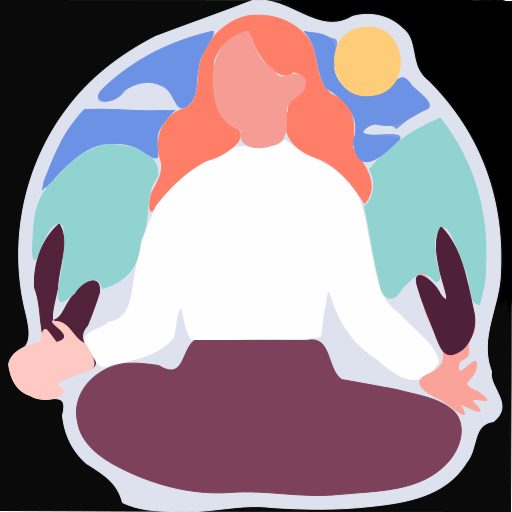

128\meditation.png vs SVG2PNG_128\meditation.png: 37.0652707417806
128\emoji_u1faf3.png:out  179


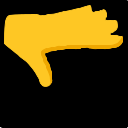

128\emoji_u1faf3.png vs SVG2PNG_128\emoji_u1faf3.png: 5.947489420572917
128\work-from-home.png:out  200


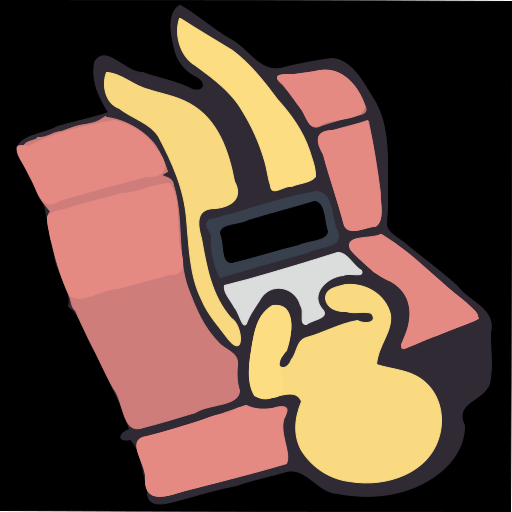

128\work-from-home.png vs SVG2PNG_128\work-from-home.png: 22.87158457438151
128\emoji_u1faf3_1f3fb.png:out  200


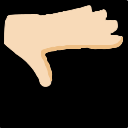

128\emoji_u1faf3_1f3fb.png vs SVG2PNG_128\emoji_u1faf3_1f3fb.png: 7.978413899739583
128\dolphin.png:out  200


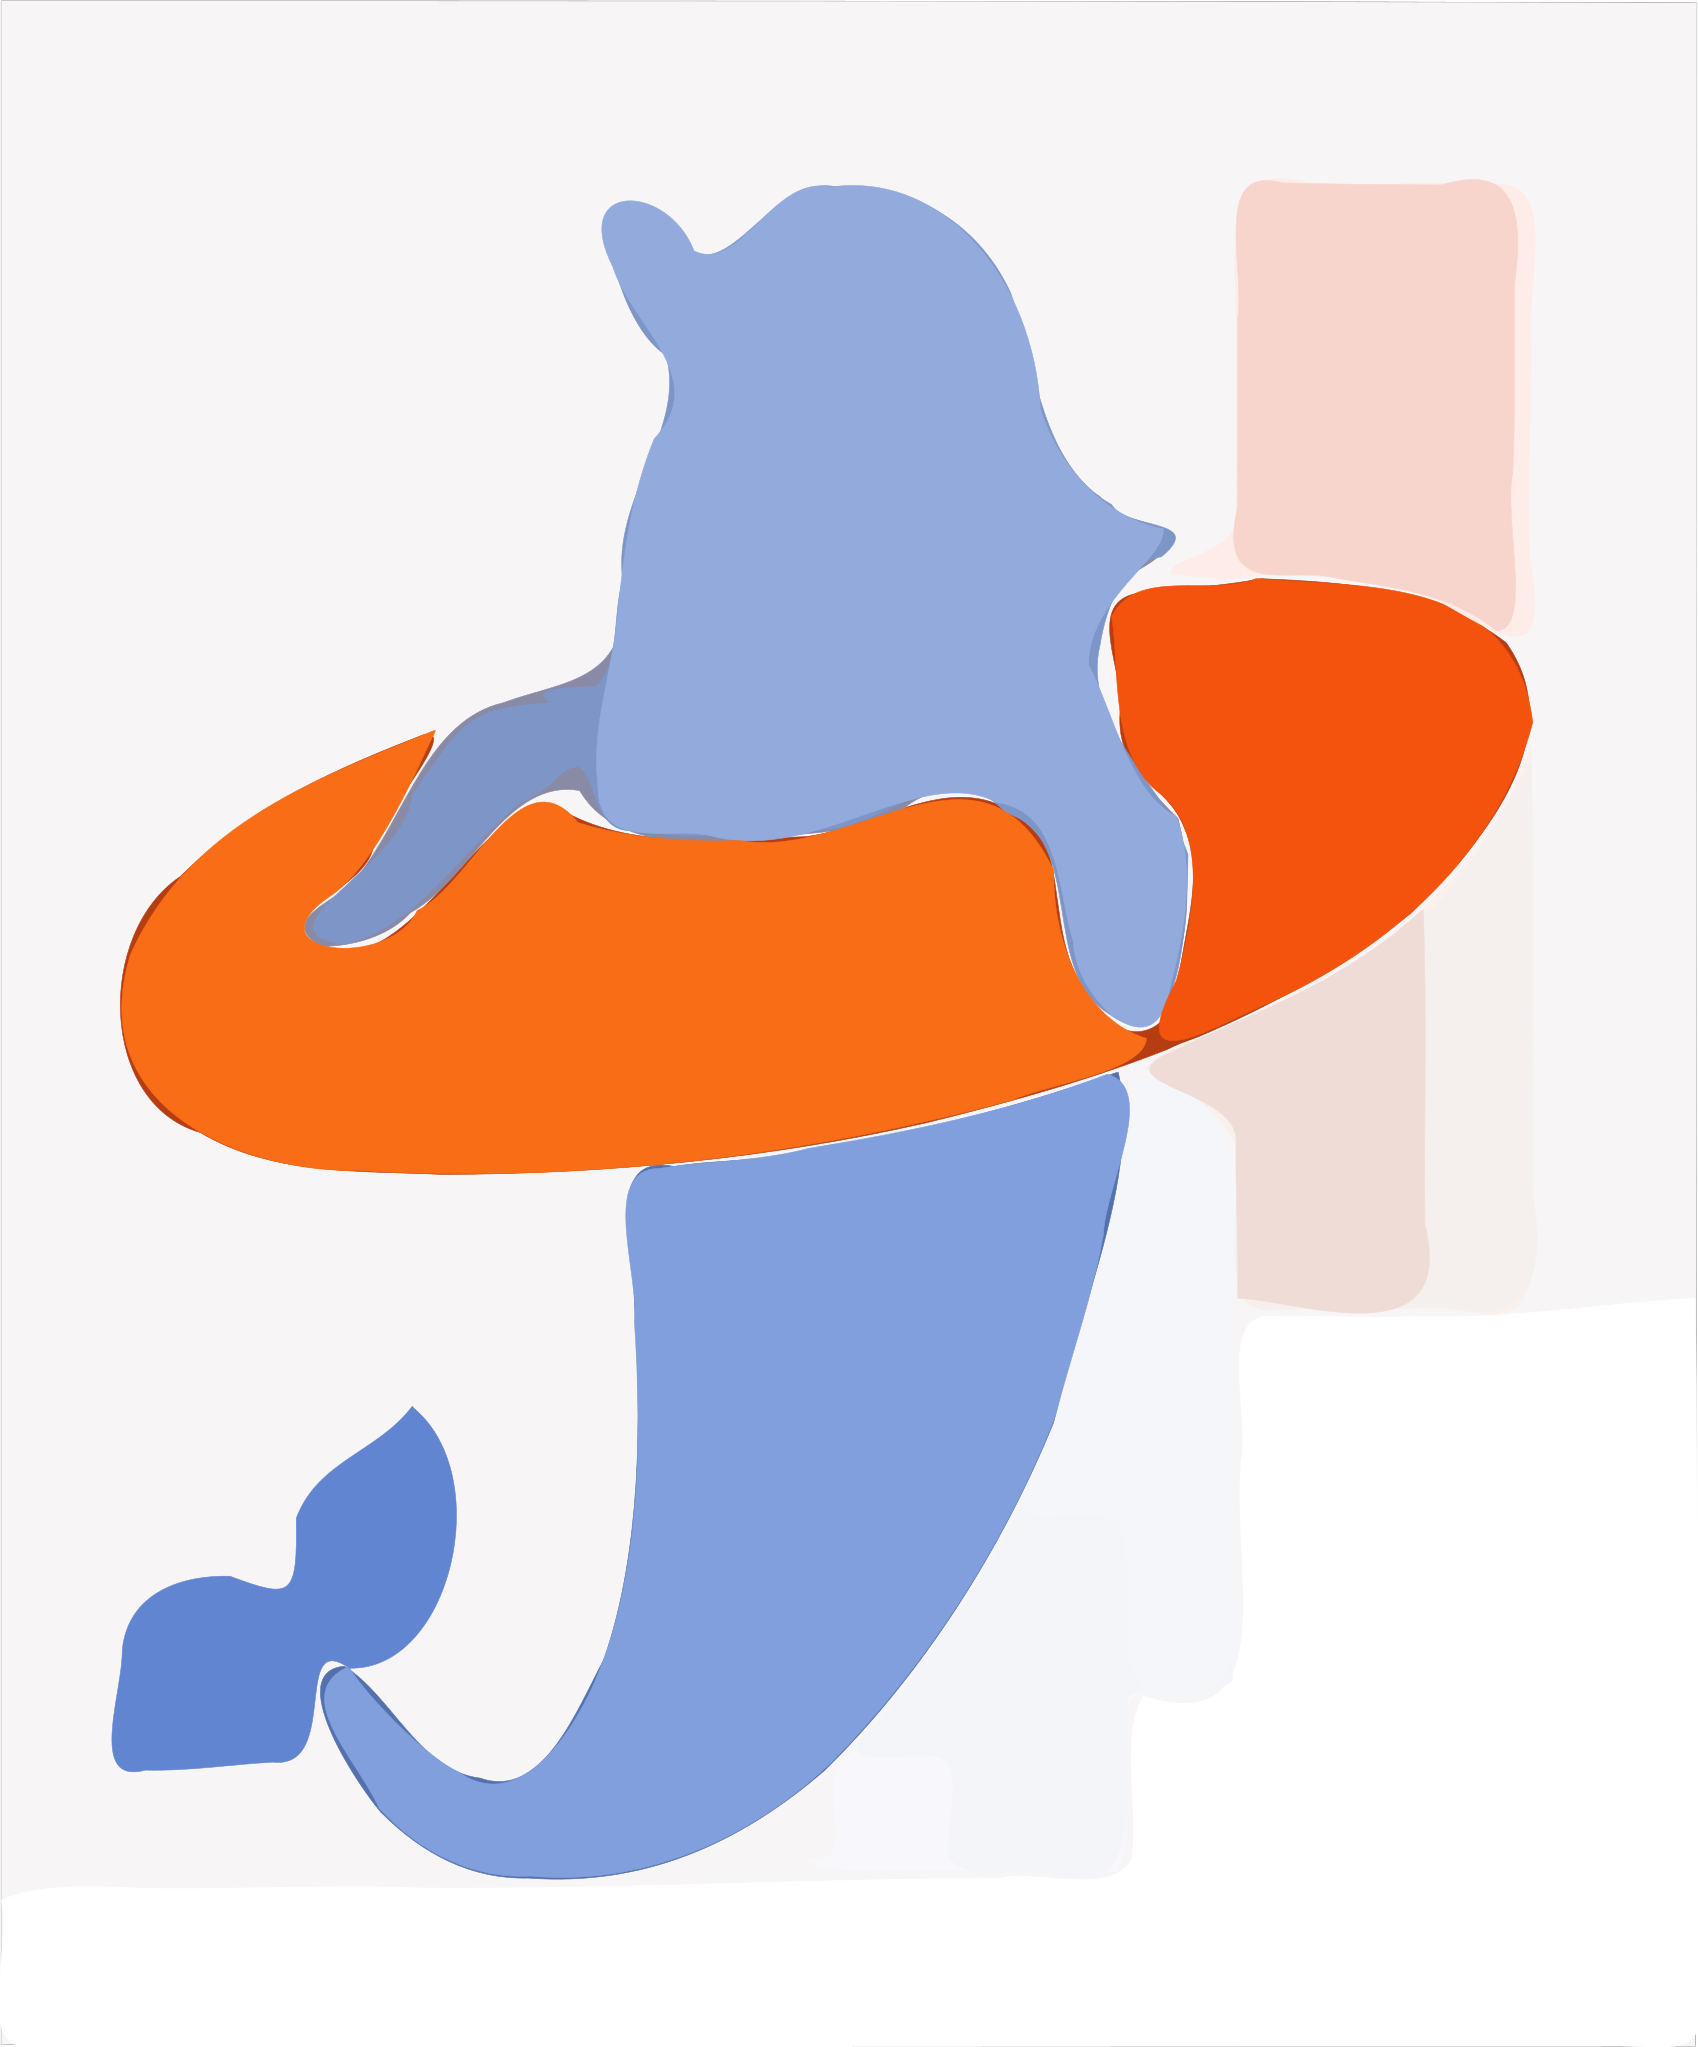

128\dolphin.png vs SVG2PNG_128\dolphin.png: 66.43557228365992
128\autumn_01.png:out  200


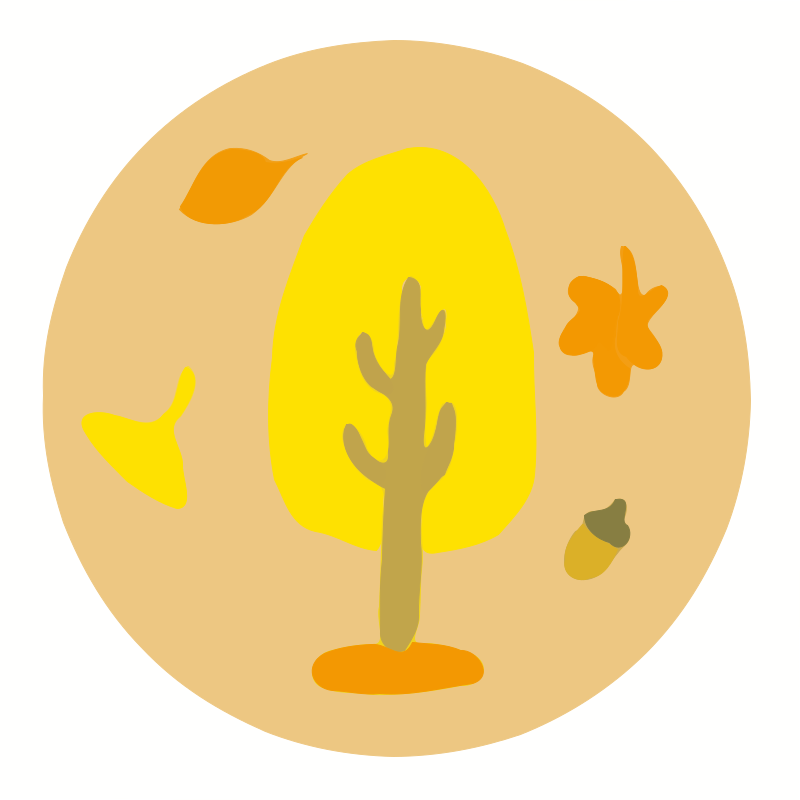

128\autumn_01.png vs SVG2PNG_128\autumn_01.png: 2.064702083333333


In [8]:
import os

gtkbin = r'C:\Program Files\GTK3-Runtime Win64\bin'
add_dll_dir = getattr(os, 'add_dll_directory', None)
if callable(add_dll_dir):
    add_dll_dir(gtkbin)
else:
    os.environ['PATH'] = os.pathsep.join((gtkbin, os.environ['PATH']))

import glob
import random
from cairosvg import svg2png
from IPython.display import display, SVG


image_paths=glob.glob(image_floder+"/*.jpg")+glob.glob(image_floder+"/*.png")
# random.shuffle(image_paths)

for image_path in image_paths:
    SAMVGV1(image_path)

    #convert SVG to PNG
    svg_path = 'SVG_' + image_path.split('.')[0]+'.svg'
    write_path = 'SVG2PNG_' + image_path.split('.')[0] + '.png'
    # Display an SVG file directly from its path
    display(SVG(filename=svg_path))
    svg2png(url=svg_path, write_to=write_path, unsafe=True)
    print(image_path +" vs " + write_path + ": " + str(calculate_mse(image_path, write_path)))
